In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

import scTRS.util as util
import scTRS.method as md
import scTRS.data_loader as dl
import submitit
import numpy as np
from anndata import read_h5ad
from statsmodels.stats.multitest import multipletests

import pandas as pd
import os
from os.path import join
import itertools
import pickle
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt

# constants
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
SCORE_FILE_DIR = join(DATA_PATH, "score_file")

TRAIT_LIST = ['PASS_Schizophrenia_Ruderfer2018',
              'PASS_BipolarDisorder_Ruderfer2018',
              'PASS_Alzheimers_Jansen2019', 
              'PASS_AdultOnsetAsthma_Ferreira2019',
              'PASS_Coronary_Artery_Disease', 
              'PASS_LargeArteryStroke_Malik2018', 
              'PASS_HDL', 'PASS_LDL',
              'PASS_Rheumatoid_Arthritis', 'PASS_Lupus', 
              'PASS_FastingGlucose_Manning',
              'PASS_IBD_deLange2017', 
              'PASS_Type_1_Diabetes', 
              'PASS_Type_2_Diabetes']

SCORE_ADATA = read_h5ad("/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/tabula_muris_senis/tabula-muris-senis-facs-official-raw-obj.h5ad")
md.compute_stats(SCORE_ADATA)
PLOT_ADATA_DICT = dl.load_tms_processed('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data', data_name='facs', tissue='all')

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/scipy/sparse/data.py:133: RuntimeWarning: overflow encountered in expm1
  result = op(self._deduped_data())
/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/scipy/sparse/data.py:117: RuntimeWarning: overflow encountered in square
  return self._with_data(data ** n)
/n/home12/khou/scTRS/scTRS/method.py:394: RuntimeWarning: overflow encountered in square
  v_var = v_var - v_mean**2
/n/home12/khou/scTRS/scTRS/method.py:394: RuntimeWarning: invalid value encountered in subtract
  v_var = v_var - v_mean**2


# load_tms_processed: load facs data, tissue=[Aorta, BAT, Bladder, Brain_Myeloid, Brain_Non-Myeloid, Diaphragm, GAT, Heart, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, MAT, Mammary_Gland, Marrow, Pancreas, SCAT, Skin, Spleen, Thymus, Tongue, Trachea]


/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/anndata/compat/__init__.py:158: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/anndata/compat/__init__.py:158: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [2]:
result_dir = join(SCORE_FILE_DIR, "score.facs.gwas_max_abs_z.top500")
result_dict = {}
for trait in TRAIT_LIST:
    result_dict[trait] = pd.read_csv(join(result_dir, f"{trait}.score.gz"), sep='\t')
    
# add random traits result
result_dir = join(SCORE_FILE_DIR, "score.facs.all_size500.weight_1en2")
for rep_i in range(5):
    result_dict[f"random_{rep_i}"] = pd.read_csv(join(result_dir, f"all_size500_rep{rep_i}.score.gz"), sep='\t')

In [3]:
zsc_dict = {trait: result_dict[trait].zscore.values for trait in result_dict}
zsc_index = result_dict[trait]['index'].values
# For each trait, calculate the mean, sd, geary's C statistics for each tissue - celltype pair
# and priotorize
trs_stats = util.calculate_trs_stats(zsc_dict=zsc_dict, zsc_index=zsc_index, 
                                stats_dict = {"mean": np.mean, "sd": np.std, "gearysc": None},
                                adata=PLOT_ADATA_DICT["Liver"], stratify_by="cell_ontology_class")
trs_stats["gearysc"]

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


# Use negative controls to determine significance

In [31]:
trait = "PASS_LDL"
ctrl_zsc = pd.read_csv(f"out/celltype_hetero/{trait}.ctrl_zsc.gz", sep='\t', index_col=0)
ctrl_cols = [col for col in ctrl_zsc.columns if col.startswith("ctrl_")]

In [33]:
tissue = "Liver"
tissue_index = SCORE_ADATA.obs.index[SCORE_ADATA.obs.tissue == tissue]
tissue_ctrl_zsc = ctrl_zsc.loc[tissue_index, :]

zsc_dict = dict()
zsc_dict[trait] = tissue_ctrl_zsc[trait]
for col in ctrl_cols:
    zsc_dict[col] = tissue_ctrl_zsc[col]
    
zsc_index = tissue_index
trs_stats = util.calculate_trs_stats(zsc_dict=zsc_dict, zsc_index=zsc_index, 
                                stats_dict = {"mean": np.mean, "sd": np.std, "gearysc": None},
                                adata=PLOT_ADATA_DICT[tissue], stratify_by="cell_ontology_class")

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


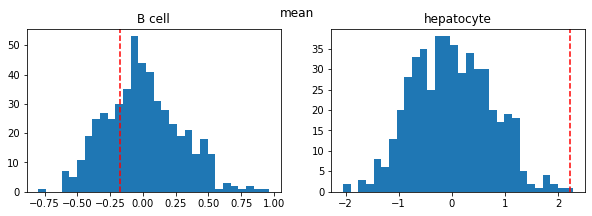

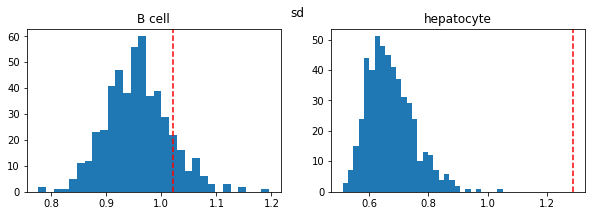

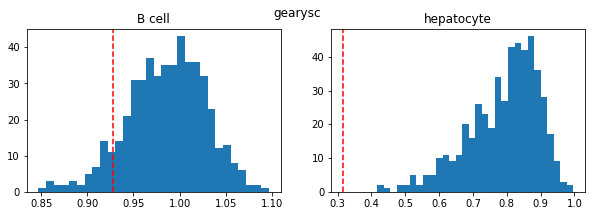

In [34]:
ct_list = ["B cell", "hepatocyte"]
for name in ["mean", "sd", "gearysc"]:
    plt.figure(figsize=(10, 3))
    for ct_i, ct in enumerate(ct_list):
        plt.subplot(1, len(ct_list), ct_i + 1)
        plt.hist(trs_stats[name].loc[ct, ctrl_cols], 30)
        plt.axvline(trs_stats[name].loc[ct, trait], ls="--", color="red")
        plt.title(ct)
    plt.suptitle(name)
    plt.show()